# grid world
Here's a little gridworld implementation that works in conjunction with [openai gym](https://gym.openai.com/). The agent (☺) can move left, right, up, and down in user-defined mazes. A `nonterminal_reward` is emited every step until one of the `terminal states` is reached, which have their own associated rewards.

Here's how we create a maze:

In [1]:
import gym
import rickgrid
import numpy as np
import matplotlib.pyplot as plt
from rickgrid import Control
from scipy.signal import medfilt

# define simple maze
np.random.seed(0)
env = gym.make('RickGrid-v0',
               walls = np.array([[0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,0,0,0]], dtype='bool'),
               terminal_states = [[0,4,1]],     # each reward is a terminal state characterized by [row, col, value]
               start_coords = [0,0],    # where the agent starts
               nonterminal_reward=-1)   # -1 per non-terminal step

We have take actions and visualize the results as follows:

In [2]:
env.render(); # show maze
env.step(1);  # step to the right
env.render(); # show maze again


██████████████
██☺   ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████

██████████████
██  ☺ ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████


# q learning
We can learn policies using action-value based tabular methods, each of which acts $\epsilon$-greedy with respect to $\hat{q}(s,a)$. Let's try the [Q-Learning implemention](https://github.com/rwarren2163/rl_sandbox/blob/71254fe327a56a019556286f7ff238e803cd9386/rickgrid/Control.py#L56):

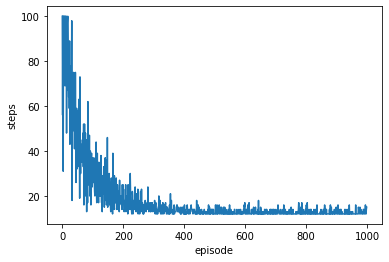

In [3]:
# set up Q Learning object
ctl = Control.QLearning(env)

# train, recording number of steps and total reward per episode
steps = ctl.train(alpha=.05, gamma=1, epsilon=.05, episodes=1000)[0];

# plot steps per episode
ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps);

The number of steps per episode decreases with learning. Nice. Note that episodes terminate automatically after 100 steps if a terminal state hasn't been reached.

Let's check out the policy by passing $\hat{q}(s,a)$ to the environment renderer:

In [4]:
env.reset()
env.render(Q=ctl.Q);


██████████████
██☺  D██ R 1██
██ D D██ R U██
██ R D██ R U██
██ D D██ U U██
██ R R R U U██
██████████████


This looks non-crazy.

Let's see how the action-value function changes over learning. Here I'm showing the value of each state (estimated as the max across actions [left column]) and the value for each of four actions estimated over the first 4 episodes. Structure in the value function emerges super quickly:

episode 1


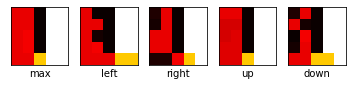

episode 2


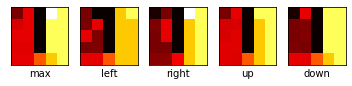

episode 3


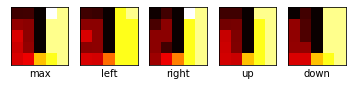

episode 4


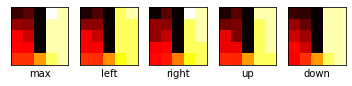

In [5]:
ctl.resetQ();  # reset Q to initial values

for i in range(1,5):
    ctl.train(alpha=.05, gamma=1, epsilon=.05, episodes=1);
    print('episode {}'.format(i))
    ctl.plotQ();
    
    

# monte carlo

Let's try the [Monte Carlo implementation](https://github.com/rwarren2163/rl_sandbox/blob/71254fe327a56a019556286f7ff238e803cd9386/rickgrid/Control.py#L109). This is an 'every visit' Monte Carlo approach that uses a non-stationary estimate of the action-value function. The update rule is: $\hat{q}(S_t,A_t) \leftarrow \hat{q}(S_t,A_t) + \alpha[G_t - \hat{q}(S_t,A_t)]$


██████████████
██☺  D██ R 1██
██ R D██ U U██
██ R D██ R U██
██ R D██ R U██
██ R R R U U██
██████████████


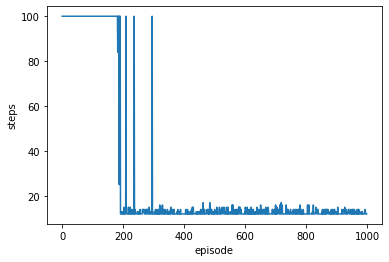

In [6]:
# set up Monte Carlo object
ctl = Control.MonteCarlo(env)

# train, recording number of steps per episode
steps = ctl.train(alpha=.05, gamma=1, epsilon=.05, episodes=1000)[0]

# show policy
env.reset()
env.render(Q=ctl.Q);

# plot steps per episode
ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps);

The learning curve is a little goofy. There seems to be an 'aha' moment. The agent has to accidentally discover the terminal location at least once before learning can really occur. This could be problematic for larger state spaces (see below).

# explore vs. exploit maze
Default mazes are defined in `rickgrid.mazes`, and include one where an agent should learn to ignore a proximal reward for a big reward that can only be discovered via exploration.



In [7]:
from rickgrid.mazes import mazes
env = gym.make('RickGrid-v0', **mazes[0])
env.render();


████████████████████████████████████████████
██☺     ██        ██                      ██
██  ██    ██████  ██  ██████████████████  ██
██    ██          ██            ██        ██
██  ██  ████████  ██  ████████████  ████████
██            ██               1██      99██
████████████████████████████████████████████


Let's apply our Q-Learning strategy from above, this time plotting the reward per episode:

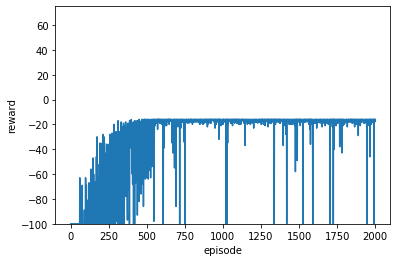

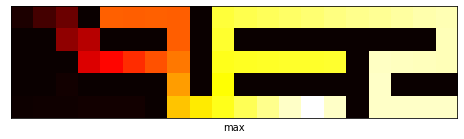

In [8]:
ctl = Control.QLearning(env)
rewards = ctl.train(alpha=.05, gamma=1, epsilon=.05, episodes=2000)[1]

# plot rewards and value function
ax = plt.axes(xlabel='episode', ylabel='reward', ylim=[-100,75])
ax.plot(rewards);
ctl.plotQ(figsize=(8,32), max_only=True)

The reward has plateaued around -20. This is much lower that what the agent would get if the 99 reward were discovered. The value function reveals why. The corridor with the 1 is drawing the agent in, leaving the more valuable corridor insufficiently explored. Let's fix this.

## fix 1: optimism in the face of uncertainty

Let's initialize the $\hat{q}(s,a)$ with exremely optimistic values of 99. This will encourage the agent to explore the unexplored, ultimately discovering the big reward.

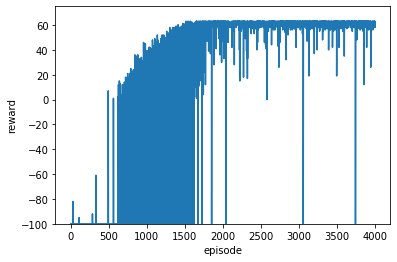

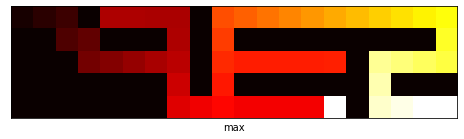

In [9]:
ctl = Control.QLearning(env, Q_init=99)  # initialize Q with values of 99
rewards = ctl.train(alpha=.05, gamma=1, epsilon=.05, episodes=4000)[1]

# plot rewards and value function
ax = plt.axes(xlabel='episode', ylabel='reward', ylim=[-100,75])
ax.plot(rewards);
ctl.plotQ(figsize=(8,32), max_only=True)

Take a look at the policy below. Some states that aren't visited under the policy still have weird actions (like in the lower left corner). However, this does not affect performance unless non-greedy actions pull the agent to these strange corners of state space.

In [10]:
env.reset()
env.render(Q=ctl.Q);


████████████████████████████████████████████
██☺  R D██ L L L R██ R R R R R R R R R R D██
██ D██ R D██████ D██ U██████████████████ D██
██ L D██ R R R R D██ U R D R D R██ D L L L██
██ R██ U████████ D██ U████████████ D████████
██ R R D U R D██ R R U L U U D 1██ R R R99██
████████████████████████████████████████████


## fix 2: exploring starts

Instead of starting the agent in the top left corner every time, let's randomize the start state. This guarantees the state space is explored, and should fix the weird decisions that are made in unvisisted states shown above. We'll need to train it for a bit longer though.

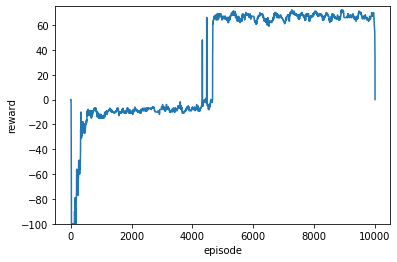

In [11]:
env_rando = gym.make('RickGrid-v0', **mazes[0], random_start=True)
ctl = Control.QLearning(env_rando)
rewards = ctl.train(alpha=.05, gamma=1, epsilon=.2, episodes=10000)[1]  # cranking up epsilon helps a lot

# plot rewards and value function
ax = plt.axes(xlabel='episode', ylabel='reward', ylim=[-100,75])
ax.plot(medfilt(rewards, 99));

It takes a while for the agent to realize it should make the long trek to the distant reward. Plotting the policy and value function as they evolve shows why:



episode 1000


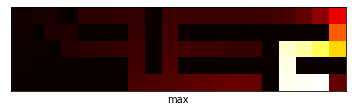


████████████████████████████████████████████
██ R R D██ U D L R██ R R D R D L R R R R D██
██ L██ R D██████ D██ D██████████████████ D██
██ R D██ R R R R D██ D L L U U R██ D L L L██
██ U██ U████████ D██ D████████████ D████████
██ D U D R D R██ R R R R R R R☺ ██ R R R99██
████████████████████████████████████████████


episode 4000


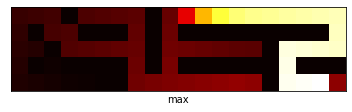


████████████████████████████████████████████
██ R R D██ U R R D██ D R R R R R R R R R D██
██ U██ R D██████ D██ D██████████████████ D██
██ U L██ R R R R D██ D L L L L U██ D L L L██
██ U██ D████████ D██ D████████████ D████████
██ U L L L U L██ R R R R R R R☺ ██ R R R99██
████████████████████████████████████████████


episode 10000


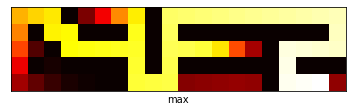


████████████████████████████████████████████
██ R R D██ R R R D██ R R R R R R R R R R D██
██ U██ R D██████ D██ U██████████████████ D██
██ U L██ R R R R D██ U L L L L L██ D L L L██
██ U██ D████████ D██ U████████████ D████████
██ U L L L L L██ R R U R R R R 1██ R R R☺ ██
████████████████████████████████████████████


In [12]:
ctl.resetQ();  # reset Q to initial values

eps = [0, 1000, 4000, 10000]

for i in range(1, len(eps)):
    ctl.train(alpha=.05, gamma=1, epsilon=.2, episodes=(eps[i]-eps[i-1]));
    print('\n\nepisode {}'.format(eps[i]))
    ctl.plotQ(max_only=True);
    env_rando.render(Q=ctl.Q);

The value must propogate backwards from the corner over time. When a location has already been 'linked' with the small reward, associating it with the path to the high reward requires that the agent take the non-greedy step in the right direction. This is why cranking up $\epsilon$ really helped in this experiment.